In [ ]:
!pip install fasttext imbalanced-learn speechrecognition nltk pandas tensorflow scikit-learn matplotlib seaborn transformers
import random
import fasttext
import numpy as np
import pandas as pd
import nltk
import speech_recognition as sr
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from transformers import AutoTokenizer, TFAutoModel
from collections import Counter
from nltk.corpus import wordnet
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 21.1 MB/s eta 0:00:00
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313502 sha256=245fc71ffb2f2e38efc4c2642f901a876b682a3b9a03fbb394e91d6afa50f35f
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# Download NLTK Resources (Run Once)
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Load Dataset
import pandas as pd

file_path = "/content/voice_labels_with_lang_indices_new.xlsx"  # The uploaded file
df = pd.read_excel(file_path)


In [ ]:
# Data Augmentation: Replace words with synonyms
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    for _ in range(n):
        word_idx = random.randint(0, len(words)-1)
        synonyms = wordnet.synsets(words[word_idx])
        if synonyms:
            words[word_idx] = synonyms[0].lemmas()[0].name()
    return " ".join(words)

In [ ]:
# Augment "normal" category
df_normal = df[df["label"] == "normal"].copy()
df_normal["comment_text"] = df_normal["comment_text"].apply(lambda x: synonym_replacement(x, n=2))

# Add Augmented Data
df = pd.concat([df, df_normal], ignore_index=True)

# Convert labels to categorical type
df["label"] = df["label"].astype("category")
df["label_encoded"] = df["label"].cat.codes  # Convert labels to numeric

# Remove NaN values
df = df.dropna(subset=["comment_text"])

# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["comment_text"].fillna(""), df["label_encoded"], test_size=0.2, random_state=42, stratify=df["label_encoded"]
)

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import numpy as np
import tensorflow as tf

# Load MuRIL tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
muril_model = TFAutoModel.from_pretrained("google/muril-base-cased")

def get_muril_embeddings(texts, batch_size=4):
    embeddings_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Tokenize and move to TensorFlow tensors (NO .to(device))
        tokens = tokenizer(batch_texts.tolist(), padding=True, truncation=True, return_tensors="tf", max_length=128)

        # No torch.no_grad() for TensorFlow; use tf.function for performance
        embeddings = muril_model(**tokens).last_hidden_state[:, 0, :].numpy()  # CLS token representation
        embeddings_list.append(embeddings)

    return np.vstack(embeddings_list)

# Process with a smaller batch size
X_train_muril = get_muril_embeddings(train_texts, batch_size=4)
X_test_muril = get_muril_embeddings(test_texts, batch_size=4)


Some layers from the model checkpoint at google/muril-base-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Apply SMOTE for balancing dataset
smote = SMOTE(k_neighbors=min(3, len(set(train_labels)) - 1), random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_muril, train_labels)

print("Class Distribution After SMOTE:", Counter(y_resampled))

Class Distribution After SMOTE: Counter({2: 16845, 5: 16845, 1: 16845, 0: 16845, 3: 16845, 4: 16845})


In [ ]:
# Reshape input data to add a sequence dimension
X_resampled = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])
X_test_muril = X_test_muril.reshape(X_test_muril.shape[0], 1, X_test_muril.shape[1])

# Train BiLSTM Model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(df["label"].unique()), activation="softmax")  # Output layer with softmax activation
])

lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
lstm_model.fit(X_resampled, y_resampled, epochs=25, batch_size=16, validation_data=(X_test_muril, test_labels))

Epoch 1/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - accuracy: 0.5702 - loss: 0.9622 - val_accuracy: 0.9278 - val_loss: 0.1693
Epoch 2/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.8478 - loss: 0.3047 - val_accuracy: 0.9461 - val_loss: 0.1169
Epoch 3/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8783 - loss: 0.2424 - val_accuracy: 0.9375 - val_loss: 0.1572
Epoch 4/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8923 - loss: 0.2159 - val_accuracy: 0.9458 - val_loss: 0.1437
Epoch 5/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9084 - loss: 0.1913 - val_accuracy: 0.9668 - val_loss: 0.0771
Epoch 6/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9161 - loss: 0.1789 - val_accuracy: 0.9411 - val_loss: 0.1571
Epoch 7/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9239 - loss: 0.1660 - val_accuracy: 0.9669 - val_loss: 0.0789
Epoch 8/25
6317/6317 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9296 - lo

In [ ]:
# Train Random Forest Classifier
# Reshape X_resampled back to 2D for Random Forest
X_resampled_2d = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[2])

rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_resampled_2d, y_resampled) # Use the reshaped data here

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [ ]:
# Function for Final Prediction
def final_prediction(text):
    """ Predict category of the given text using BiLSTM + RandomForest """
    muril_embedding = get_muril_embeddings(pd.Series([text]))

    # LSTM prediction
    # Reshape muril_embedding to match the expected input shape of the LSTM model
    muril_embedding = muril_embedding.reshape(muril_embedding.shape[0], 1, muril_embedding.shape[1])
    lstm_pred_probs = lstm_model.predict(muril_embedding)
    lstm_pred_label = np.argmax(lstm_pred_probs, axis=1)[0]

    # RandomForest prediction
    # Reshape muril_embedding back to 2D for Random Forest
    muril_embedding = muril_embedding.reshape(muril_embedding.shape[0], muril_embedding.shape[2])
    rf_pred_label = rf_model.predict(muril_embedding)[0]

    # Ensemble (Weighted Majority Voting)
    final_pred_label = lstm_pred_label if lstm_pred_probs[0][lstm_pred_label] > 0.6 else rf_pred_label

    predicted_text_label = df["label"].cat.categories[final_pred_label]  # Convert back to original label
    return predicted_text_label

In [ ]:
# Speech-to-Text Function
def speech_to_text():
    """ Capture voice input and convert it to text """
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("🎙 Speak something...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

    try:
        text = recognizer.recognize_google(audio)  # Convert speech to text
        print(f"📝 Recognized Text: {text}")
        return text
    except sr.UnknownValueError:
        print("❌ Could not understand audio")
        return None
    except sr.RequestError:
        print("❌ Error with the Speech Recognition API")
        return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

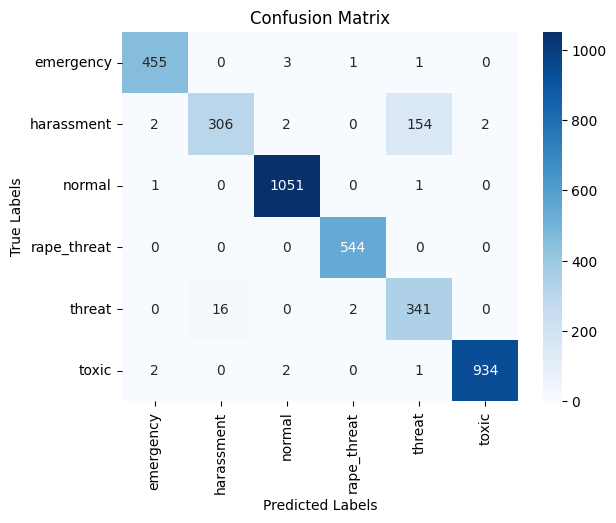

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset (Ensure the file path is correct)
file_path = "/content/voice_labels_with_lang_indices_new.xlsx"
df = pd.read_excel(file_path)

# Convert 'label' column to category dtype (Fix the error)
df["label"] = df["label"].astype("category")

# Encode labels if not already encoded
if "label_encoded" not in df.columns:
    df["label_encoded"] = df["label"].cat.codes  # Use cat.codes to encode categorical labels

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["comment_text"].fillna(""), df["label_encoded"], test_size=0.2, random_state=42, stratify=df["label_encoded"]
)

# Generate predictions
y_pred = [final_prediction(text) for text in test_texts]

# Convert predictions to numerical labels for evaluation
label_mapping = {label: i for i, label in enumerate(df["label"].cat.categories)}
y_pred_num = [label_mapping[pred] for pred in y_pred]

test_labels_num = test_labels.tolist()  # Convert test_labels to a list

# Evaluate Accuracy
accuracy = accuracy_score(test_labels_num, y_pred_num)
print(f"📌 Improved Model Accuracy: {accuracy:.4f}")

# Classification Report
print(classification_report(test_labels_num, y_pred_num, target_names=df["label"].cat.categories))

# Confusion Matrix
cm = confusion_matrix(test_labels_num, y_pred_num)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df["label"].cat.categories, yticklabels=df["label"].cat.categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
